In [1]:
! gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?code_challenge=psZfM5pP0ucf3jZlLbp6dzP5rxjPLREl0mTijjXHHj4&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


If you need to use ADC, see:
  gcloud auth application-default --help

You are now logged in as [galli.giuly@gmail.com].
Your current project is [reddit-master].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [2]:
!gcloud config set project reddit-master

Updated property [core/project].


In [3]:
!gsutil ls gs://reddit_final_results/

gs://reddit_final_results/comments_posts_2018.csv
gs://reddit_final_results/comments_posts_2018.zip
gs://reddit_final_results/comments_posts_2018_V2.csv
gs://reddit_final_results/comments_posts_2018_V2.zip
gs://reddit_final_results/comments_posts_Fitness.pkl
gs://reddit_final_results/comments_posts_IAmA.pkl
gs://reddit_final_results/comments_posts_atheism.pkl
gs://reddit_final_results/comments_posts_aww.pkl
gs://reddit_final_results/comments_posts_europe.pkl
gs://reddit_final_results/comments_posts_funny.pkl
gs://reddit_final_results/comments_posts_gaming.pkl
gs://reddit_final_results/comments_posts_movies.pkl
gs://reddit_final_results/comments_posts_nba.pkl
gs://reddit_final_results/comments_posts_politics.pkl
gs://reddit_final_results/comments_posts_science.pkl
gs://reddit_final_results/comments_posts_technology.pkl
gs://reddit_final_results/comments_posts_todayilearned.pkl
gs://reddit_final_results/comments_posts_tokenized.csv
gs://reddit_final_results/comments_posts_tokenized.zip
g

In [4]:
!gsutil cp gs://reddit_final_results/red_comments_posts.csv .

Copying gs://reddit_final_results/red_comments_posts.csv...
/ [1 files][561.1 MiB/561.1 MiB]    2.7 MiB/s                                   
Operation completed over 1 objects/561.1 MiB.                                    


In [6]:
import numpy as np 
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
import logging
import nltk
nltk.download('stopwords')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.metrics import accuracy_score
from utils import clean_text_keras
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from IPython.core.interactiveshell import InteractiveShell
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [116]:
#subreddits = ['aww', 'nba', 'movies', 'todayilearned', 'IAmA', 'Fitness', 'worldnews', 'technology', 'europe', 'politics', 'atheism','science', 'funny', 'gaming']

model_LSTM_df = pd.read_csv('red_comments_posts.csv', index_col=[0])

/nix/store/94jxlqmlr777cnw3wa9ycx6651hdpzg5-python3.7-ipython-7.8.0/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



In [117]:
model_LSTM_df.head()

,subreddit,body
0,funny,Did a hell of a job with the blue duck then if...
1,funny,And the ones who don't will settle because at ...
2,funny,My grand father fished cods like this 50 years...
3,funny,It’s fake yes but how did they do it? The eff...
4,funny,They should have smoke bombs that have bug poi...


In [118]:
model_LSTM_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2164603 entries, 0 to 2164568
Data columns (total 2 columns):
subreddit    object
body         object
dtypes: object(2)
memory usage: 49.5+ MB


In [119]:
#iama, funny, til, worldnews
model_LSTM_df = model_LSTM_df[model_LSTM_df['subreddit'] != 'funny']
model_LSTM_df = model_LSTM_df[model_LSTM_df['subreddit'] != 'todayilearned']
model_LSTM_df = model_LSTM_df[model_LSTM_df['subreddit'] != 'IAmA']
model_LSTM_df = model_LSTM_df[model_LSTM_df['subreddit'] != 'worldnews']

In [120]:
model_LSTM_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1546852 entries, 153643 to 2164568
Data columns (total 2 columns):
subreddit    1546818 non-null object
body         1546818 non-null object
dtypes: object(2)
memory usage: 35.4+ MB


In [121]:
model_LSTM_df.subreddit.value_counts()

gaming        155224
atheism       155224
Fitness       155224
europe        155224
nba           155224
movies        155224
politics      154188
technology    153880
science       153750
aww           153656
Name: subreddit, dtype: int64

In [122]:
model_LSTM_df['subreddit'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='number of posts', 
                                                                title='posts and comments per subreddit')

In [123]:
model_LSTM_df.isna().sum()
model_LSTM_df = model_LSTM_df.dropna()
model_LSTM_df.isna().sum()

subreddit    34
body         34
dtype: int64

subreddit    0
body         0
dtype: int64

From the previous execution (08.06_LSTM_keras.ipynb), I have moved the clean_text function to the **utils** module, saved it as **clean_text_keras**, and used it here (instead of copy-pasting it)

In [128]:
model_LSTM_df['body'] = model_LSTM_df['body'].apply(clean_text_keras)

In [129]:
model_LSTM_df.head()

,subreddit,body
153643,nba,dont think kawhi rest team valid say brought u...
153644,nba,meyers deal never defendable resigning price w...
153645,nba,thought read something wanting go lakers simil...
153646,nba,posted thread buthes actually trying old himym...
153647,nba,played 2 years thought untouchable


In [130]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 450
EMBEDDING_DIM = 100

In [131]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,)
tokenizer.fit_on_texts(model_LSTM_df['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 851625 unique tokens.


In [134]:
with open('tokenizer_keras.pkl', 'wb') as file:
    pkl.dump(tokenizer, file)
    
!gsutil cp tokenizer_keras.pkl gs://reddit_models/

Copying file://tokenizer_keras.pkl [Content-Type=application/octet-stream]...
- [1 files][ 46.3 MiB/ 46.3 MiB]                                                
Operation completed over 1 objects/46.3 MiB.                                     


In [21]:
X = tokenizer.texts_to_sequences(model_LSTM_df['body'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1546818, 450)


In [22]:
Y = pd.get_dummies(model_LSTM_df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1546818, 10)


In [23]:
def train_dev_test_split(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)
    return (X_train,
                X_val,
                X_test,
                y_train,
                y_val,
                y_test)


X_train, X_val, X_test, Y_train, Y_val, Y_test = train_dev_test_split(X,Y)

print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(1082772, 450) (1082772, 10)
(232023, 450) (232023, 10)
(232023, 450) (232023, 10)


# Approaching LSTM

I'll using a LSTM of 30 units, 5 epochs, and a batch size of 512

In [26]:
import keras.backend as K
import keras

K.clear_session()

# Creating the neural network using Keras' functional api so that
# I'm able to inspect each one of the layers later.

inpt = Input(shape=(MAX_SEQUENCE_LENGTH,)) 
emb = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(inpt)
dropout = SpatialDropout1D(0.2)(emb)
lstm = LSTM(30, dropout=0.2, recurrent_dropout=0.2)(dropout)
output = Dense(10, activation='softmax')(lstm)
model = Model(inputs =[inpt], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 450)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 450, 100)          7500000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 450, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 7,516,030
Trainable params: 7,516,030
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
epochs = 10
batch_size = 150
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    min_delta=0.01)

history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Train on 1082772 samples, validate on 232023 samples
Epoch 1/10
1082772/1082772 [==============================] - 1951s 2ms/step - loss: 1.1177 - accuracy: 0.6411 - val_loss: 0.9680 - val_accuracy: 0.6893
Epoch 2/10
1082772/1082772 [==============================] - 2173s 2ms/step - loss: 0.9248 - accuracy: 0.7025 - val_loss: 0.9462 - val_accuracy: 0.6944
Epoch 3/10
1082772/1082772 [==============================] - 2443s 2ms/step - loss: 0.8689 - accuracy: 0.7184 - val_loss: 0.9491 - val_accuracy: 0.6946


In [ ]:
emb

In [28]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

232023/232023 [==============================] - 188s 812us/step
Test set
  Loss: 0.944
  Accuracy: 0.697


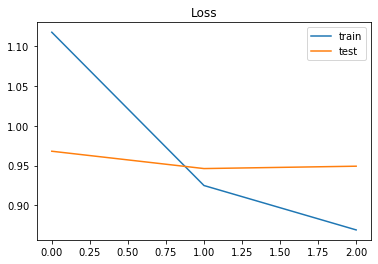

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

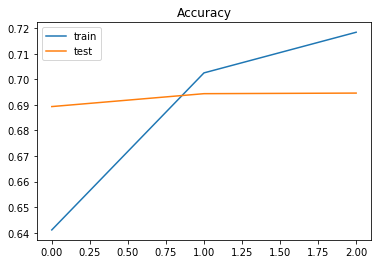

In [30]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [32]:
model.save('red_model_lstm_30_batchsize_150_10_subreddits.h5')

In [33]:
!gsutil cp red_model_lstm_30_batchsize_150_10_subreddits.h5 gs://reddit_models

Copying file://red_model_lstm_30_batchsize_150_10_subreddits.h5 [Content-Type=application/octet-stream]...
\ [1 files][ 86.0 MiB/ 86.0 MiB]    4.6 MiB/s                                   
Operation completed over 1 objects/86.0 MiB.                                     


In [36]:
import keras
model = keras.models.load_model('red_model_lstm_30_batchsize_150_10_subreddits.h5')

subreddits = model_LSTM_df['subreddit'].unique()

# mapping subreddit to one hot encoding of subreddit
oho_mapping = {}

oho = pd.get_dummies(model_LSTM_df['subreddit'])

for subreddit in subreddits:
    oho_mapping[subreddit] = oho[oho[subreddit] == 1].iloc[0].values

MAX_SEQUENCE_LENGTH = 450    
NUMBER_OF_TEXTS = 10000

for subreddit in subreddits:
    df = model_LSTM_df[model_LSTM_df['subreddit'] == subreddit]
    Y = np.matrix([oho_mapping[subreddit] for i in range(0, NUMBER_OF_TEXTS)])
    X = pad_sequences(tokenizer.texts_to_sequences(df['body'].sample(NUMBER_OF_TEXTS).values), maxlen=MAX_SEQUENCE_LENGTH)
    accr = model.evaluate(X,Y)
    print("training " + subreddit)
    print(accr)

10000/10000 [==============================] - 8s 828us/step
training nba
[0.5583630716323853, 0.8355000019073486]
10000/10000 [==============================] - 8s 823us/step
training europe
[0.8516529379844665, 0.7132999897003174]
10000/10000 [==============================] - 8s 826us/step
training gaming
[0.8529842687606811, 0.7184000015258789]
10000/10000 [==============================] - 8s 818us/step
training movies
[0.8326383893013001, 0.7383999824523926]
10000/10000 [==============================] - 8s 830us/step
training technology
[1.0579157430648805, 0.6226000189781189]
10000/10000 [==============================] - 8s 824us/step
training aww
[0.7697437300443649, 0.776199996471405]
10000/10000 [==============================] - 8s 838us/step
training politics
[1.0362028932571412, 0.6650000214576721]
10000/10000 [==============================] - 8s 829us/step
training Fitness
[0.3501020720779896, 0.899399995803833]
10000/10000 [==============================] - 8s 833us/s

In [112]:
import tensorflow
tensorflow.python.keras.backend??

In [106]:
Y_predicted

array([[9.00699198e-03, 4.51023970e-03, 8.62935483e-01, ...,
        2.07041996e-03, 6.42776340e-02, 9.39771254e-03],
       [6.30877257e-05, 1.97597226e-04, 2.61415291e-04, ...,
        4.24243248e-04, 4.98241352e-05, 4.23787744e-04],
       [2.67660769e-04, 1.61342614e-03, 1.19123829e-03, ...,
        2.44888652e-04, 7.52904089e-05, 4.35557129e-04],
       ...,
       [5.49060642e-04, 6.84184954e-02, 4.14810032e-02, ...,
        4.42766137e-02, 4.61723395e-02, 4.59356904e-02],
       [1.92680676e-02, 1.35851875e-02, 2.03153461e-01, ...,
        1.00834528e-02, 2.01463904e-02, 1.07623572e-02],
       [1.05316380e-04, 7.92726636e-01, 1.80109986e-03, ...,
        1.74025163e-01, 5.87445125e-03, 9.85587109e-03]], dtype=float32)

In [104]:
def convert_to_cat(arr):
    i = 0
    for x in range(0, len(arr)):
        if int(round(arr[x])) == 1:
            i = x
    return i
    
Y_test_converted = [convert_to_cat(x) for x in Y_test]
Y_predicted_converted = [convert_to_cat(x) for x in Y_predicted]

In [100]:
accuracy_score(Y_predicted_converted, Y_test_converted)

0.6233261357710227

In [42]:
len(Y_predicted)

1082772

# Visualization

<BarContainer object of 10 artists>

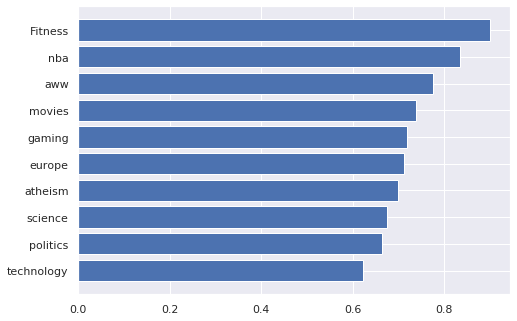

In [26]:
import collections

subreddits = {
    'nba': 0.8355000019073486,
    'europe': 0.7132999897003174,
    'gaming': 0.7184000015258789,
    'movies': 0.7383999824523926,
    'technology': 0.6226000189781189,
    'aww': 0.776199996471405,
    'politics': 0.6650000214576721,
    'Fitness': 0.899399995803833,
    'atheism': 0.6991000175476074,
    'science': 0.6759999990463257
}

sort = collections.OrderedDict(sorted(subreddits.items(), key=lambda kv: kv[1]))

figure = plt.figure()
ax = figure.add_axes([0,0,1,1])

ax.barh(list(sort.keys()), list(sort.values()))
plt.show()